In [1]:
%matplotlib inline
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/Users/rezaie/github/LSSutils')
from lssutils.stats.cl import AnaFast
from lssutils.utils import mask2regions
from scipy.interpolate import interp1d
from lssutils.clustering import ddthetahpauto
from time import time

In [2]:
def gauleg(ndeg, a=-1.0, b=1.0):
    '''
       Gauss-Legendre (default interval is [-1, 1])
    '''
    x, w = np.polynomial.legendre.leggauss(ndeg)
    # Translate x values from the interval [-1, 1] to [a, b]
    t = 0.5*(x + 1)*(b - a) + a
    w *= 0.5*(b - a)
    return t, w

def xi2cl(x, w, xi, nlmax):
    '''
        calculates Cell from omega
    '''
    cl  = []
    xiw = xi*w
    for i in range(nlmax+1):
        Pl    = np.polynomial.Legendre.basis(i)(x)
        cl.append((xiw * Pl).sum())
        
    cl = 2.*np.pi*np.array(cl)
    return cl

def cl2xi(cell, costheta):
    '''
        calculates omega from Cell at Cos(theta)
    '''
    ell = np.arange(cell.size)
    coef = (2*ell+1) * cell / (4.*np.pi)
    y = np.polynomial.legendre.legval(costheta, c=coef, tensor=False)
    return y


def convolve_cl(cl_true, window_spl, lmax=750, ngauss=1024):

    x, w = gauleg(ngauss)
    
    xi_mask = window_spl(x)
    xi_th = cl2xi(cl_true, x)
    xi_thw = xi_th * xi_mask
    cl_thw = xi2cl(x, w, xi_thw, lmax)
    
    return cl_thw


class WindowRR:
    def __init__(self, rr_file, ntot, npix):
        
        area = ntot / npix
        
        raw_data = np.load(rr_file, allow_pickle=True)
        sep = raw_data[0][::-1]           # in radians
        rr_counts = raw_data[1][::-1]*2.0 # paircount uses symmetry

        sep_mid = 0.5*(sep[1:]+sep[:-1])
        dsep = np.diff(sep)        
        window = rr_counts / (dsep*np.sin(sep_mid)) * (2./(npix*npix*area))
        
        self.window_spl = interp1d(np.cos(sep_mid), window, fill_value="extrapolate")
    
    def convolve(self, cl_true, lmax=750, ngauss=1024):
        return convolve_cl(cl_true, self.window_spl, lmax=lmax, ngauss=ngauss)
    
    
class WindowSHT:
    
    def __init__(self, cl_file):
        cl_mask = np.load(cl_file, allow_pickle=True)
        l = cl_mask['l']
        cl = cl_mask['cl']
        xi_zero = (cl*(2*l+1)).sum() / (4.0*np.pi)
        
        cossep = np.cos(np.arange(0.0, np.pi, 0.0001))        
        xi_mask = cl2xi(cl, cossep) / xi_zero
        
        self.window_spl = interp1d(cossep, xi_mask, fill_value="extrapolate")
        
    def convolve(self, cl_true, lmax=750, ngauss=1024):
        return convolve_cl(cl_true, self.window_spl, lmax=lmax, ngauss=ngauss)

In [3]:
#
cls = np.load('cl_mocks_1k.npz', allow_pickle=True)

cl_true = cls['true']
cl_masked = np.mean(cls['masked'], axis=0)
cl_fullsky = np.mean(cls['full'], axis=0)

In [5]:
#--- run once
mask_ = hp.read_map('/Volumes/TimeMachine/data/DR7/mask.cut.hp.256.fits', verbose=False) > 0
mask_ = mask2regions(mask_)[0] # NGC
mask = hp.ud_grade(mask_, 512)
theta, phi = hp.pix2ang(512, np.argwhere(mask).flatten())

angles  = np.arange(0.0, np.pi, 0.01)
bins    = np.cos(angles)[::-1]

t0 = time()
c = ddthetahpauto(theta, phi, 1.0*mask[mask], mask[mask]*1.0, bins)
t1 = time()
print('time : ', t1-t0)
np.save('rr_window_512', [angles[::-1], c[0]])

/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


time :  8965.215007066727


/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [7]:
2 

2

In [36]:
rr_file = './rr_window.npy'
ntot = 107300.0
npix = 12*256*256

wd = WindowRR(rr_file, ntot, npix)
cl_true_rr = wd.convolve(cl_true, lmax=460, ngauss=5000)

In [13]:
#--- run once
# af = AnaFast()
# mask_ = hp.read_map('/Volumes/TimeMachine/data/DR7/mask.cut.hp.256.fits', verbose=False) > 0
# mask = mask2regions(mask_)[0] # NGC
# cl_mask = af(mask*1.0, mask*1.0, mask, lmax=750)
# np.savez('cl_mask.npz', **cl_mask)

cl_file = './cl_mask.npz'
ws = WindowSHT(cl_file)
cl_true_sh = ws.convolve(cl_true, lmax=460, ngauss=5000)

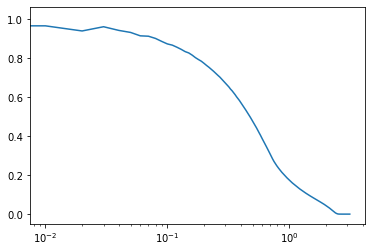

In [37]:
plt.plot(angles, wd.window_spl(bins[::-1]))
plt.xscale('log')

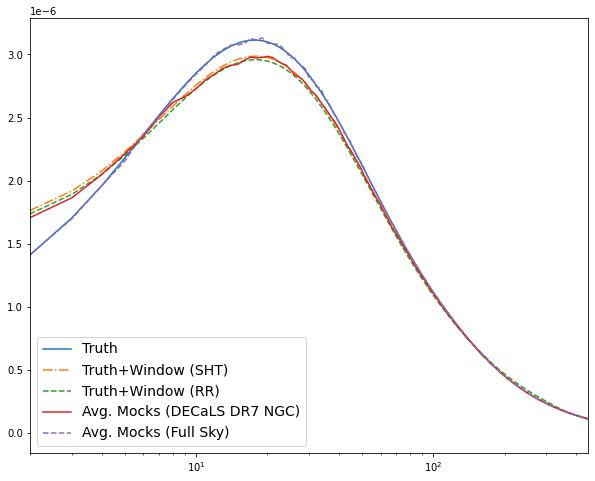

In [38]:
plt.figure(figsize=(10, 8))
plt.plot(cl_true, 'C0-',
         cl_true_sh, 'C1-.',
         cl_true_rr, 'C2--',)

plt.plot(cl_masked, 'C3-')
plt.plot(cl_fullsky, 'C4--')


plt.legend(['Truth', 
            'Truth+Window (SHT)',
            'Truth+Window (RR)', 
            'Avg. Mocks (DECaLS DR7 NGC)',
            'Avg. Mocks (Full Sky)'], fontsize=14)

plt.xlim(2, 450)
plt.xscale('log')

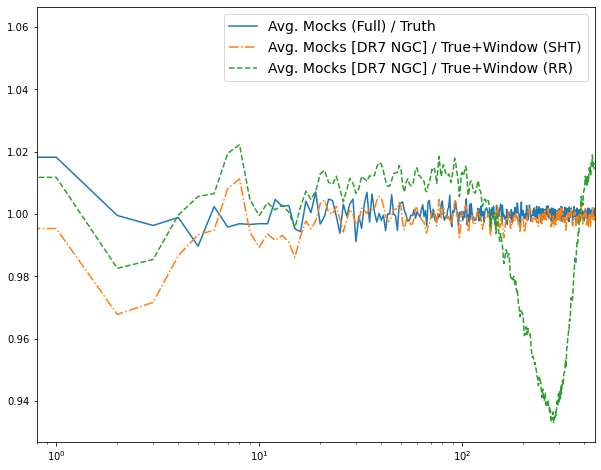

In [39]:
plt.figure(figsize=(10, 8))

plt.plot(cl_fullsky[:450]/cl_true[:450], 'C0-',
         cl_masked[:450]/cl_true_sh[:450], 'C1-.',
         cl_masked[:450]/cl_true_rr[:450], 'C2--')

plt.legend(['Avg. Mocks (Full) / Truth',
           'Avg. Mocks [DR7 NGC] / True+Window (SHT)',
           'Avg. Mocks [DR7 NGC] / True+Window (RR)'], fontsize=14)

plt.xlim(0.8, 450)
plt.xscale('log')